### Simulation

* make 4 sets of sequences: 250 seq , 1000 seqs, 5000 seqs, each 250 bp (meme takes 60000 only)
    * Use random generator with real frequencies
* Insert real motifs but have been modified to have mC.
    * CEBPB , NRF1, SP1, CTCF, made up motif
* Different abundances: 1%, 2%, 5%, 10%, 25% of peaks
    

In [19]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [100]:
import os 
from sys import argv
import random as rd
from copy import deepcopy

def load_motifsEF(filename):
    file=open(filename)
    seq=file.read().split("MOTIF")
    seq=seq[1:]
    motifs={}
    infos={}
    for s in range(len(seq)):
        t=seq[s].strip().split("\n")
        motifs[t[0]]=t[2:]  #remove HOCOMOCO URL
        infos[t[0].split('_')[0]]=t[:2]
    for m in motifs:
        tdict={'A':[],'C':[],'G':[],'T':[],'E':[],'F':[]}
        for pos in range(len(motifs[m])):
            tmp=motifs[m][pos].strip().split("\t")
            tdict['A']+=[float(tmp[0])]
            tdict['C']+=[float(tmp[1])]
            tdict['G']+=[float(tmp[2])]
            tdict['T']+=[float(tmp[3])]
            tdict['E']+=[float(tmp[4])]
            tdict['F']+=[float(tmp[5])]
        motifs[m]=tdict
    
    return motifs,infos


def load_motifs(filename):
    file=open(filename)
    seq=file.read().split("MOTIF")
    seq=seq[1:]
    motifs={}
    infos={}
    for s in range(len(seq)):
        t=seq[s].strip().split("\n")
        motifs[t[0]]=t[2:-1]  #remove HOCOMOCO URL
        infos[t[0].split('_')[0]]=t[:2]
    for m in motifs:
        tdict={'A':[],'C':[],'G':[],'T':[]}
        for pos in range(len(motifs[m])):
            tmp=motifs[m][pos].strip().split("\t")
            tdict['A']+=[float(tmp[0])]
            tdict['C']+=[float(tmp[1])]
            tdict['G']+=[float(tmp[2])]
            tdict['T']+=[float(tmp[3])]
            #tdict['E']+=[float(tmp[4])]
            #tdict['F']+=[float(tmp[5])]
        motifs[m]=tdict
    
    return motifs,infos
def insertBaseToPWM(pwm,loc,prop):
    #randomly insert modified bases to an existing pwm
    #insert at loc location, probability is prop
    newpwm = deepcopy(pwm)
    k = len(pwm['A'])
    base = rd.choice(['E','E']) # only adds E, for this is typeE
    freq = prop #rd.choice(range(5,10))*0.1 #prop 0.5 - 1.0
    print base,loc,freq
    newpwm['E'] = [0]*k #add other empty columns to the matrix
    newpwm['F'] = [0]*k

    for c in newpwm.keys():
        newpwm[c][loc] = (1-freq)/(len(newpwm.keys())-1)
    newpwm[base][loc] = freq
    return newpwm

def insertBaseToPWM_typeE(pwm,loc,props):
    #randomly insert modified bases to an existing pwm
    #insert at loc location, probability is prop
    newpwm = deepcopy(pwm)
    k = len(pwm['A'])
    if 'E' not in newpwm:
        newpwm['E'] = [0]*k #add another empty column to the matrix

    for c in newpwm.keys():
        newpwm[c][loc] = props[c]
    return newpwm

def randomkmer_typeEF(PWM):
    #take a PWM and randomly create a Kmer based on it
    # chance goes A->C->G->T->E->F
    kmer=""
    for pos in range(len(PWM['A'])):
        die=rd.randint(0,100000)
        if die<=PWM['A'][pos]*100000:
            kmer+='A'
        elif die<=(PWM['A'][pos]+PWM['C'][pos])*100000:
            kmer+='C'
        elif die<=(PWM['A'][pos]+PWM['C'][pos]+PWM['G'][pos])*100000:
            kmer+='G'
        elif die<=(PWM['A'][pos]+PWM['C'][pos]+PWM['G'][pos]+PWM['T'][pos])*100000:
            kmer+='T'
        elif die<=(PWM['A'][pos]+PWM['C'][pos]+PWM['G'][pos]+PWM['T'][pos]+PWM['E'][pos])*100000:
            kmer+='E'
        else:
            kmer+='F'
    return kmer

def loadFasta(filename):
    seqs = {}
    lines = open(filename).read().split('>')[1:]
    for line in lines:
        tmp = line.split('\n')
        seqs[tmp[0]] = ''.join(tmp[1:])
    return seqs

def insertoseqs(pwm,seqs,numseqtopick):
    #take pwm, the seqs, and insert the pwm to numseqtopick of the seqs 
    
    seqspicked = rd.sample(seqs.keys(),numseqtopick)
    #print seqspicked
    for s in seqspicked:
        kmer = randomkmer_typeEF(pwm)
        #print kmer
        string = list(seqs[s])
        insertloc = rd.randrange(0,len(string)-len(kmer))
        #print insertloc
        for i in xrange(len(kmer)):
            string[insertloc + i]=kmer[i]
    
        seqs[s] = ''.join(string)
    return seqs
def writeoutPWM(pwm,name,outfile):
    target = open(outfile,'w')
    target.write("MOTIF\t"+name+'\n')
    for loc in range(len(pwm['A'])):
        line = []
        for base in ['A','C','G','T','E','F']:
            if base not in pwm: continue
            line += [str(pwm[base][loc])]
        line = '\t'.join(line)
        target.write(line+'\n')
    target.close()
    return
def printPWM(pwm):
    print '\t'.join(['A','C','G','T','E','F'])
    for loc in range(len(pwm['A'])):
        line = []
        for base in ['A','C','G','T','E','F']:
            if base in pwm:
                line += [str(round(pwm[base][loc],3))]
        print '\t'.join(line)
    return
def getConsensus(pwm):
    #take the dict pwm and print the consensus of the pwm
    cnss = '' 
    for loc in range(len(pwm['A'])):
        maxbase = 'A'
        maxvalue = 0.0
        for base in pwm:
            if pwm[base][loc] > maxvalue:
                maxbase = base
                maxvalue = pwm[base][loc]
        cnss += maxbase
    return cnss

def loadMEMEfile(filename):
    file=open(filename)
    seq=file.read().split("MOTIF")
    seq=seq[1:]
    motifs={}
    infos={}
    for s in range(len(seq)):
        t=seq[s].strip().split("\n")
        name=t[0].strip()
        motifs[name]=t[2:]
        infos[name]=t[0:2]
    for m in motifs:
        tdict={'A':[],'C':[],'G':[],'T':[]}
        for pos in range(len(motifs[m])):
            tmp=motifs[m][pos].strip().split("\t")
            #if len(tmp)!=6:
                #print "ERROR: Motif matrix does not contain 6 collumn. It is not typeEF." 
                #sys.exit(1)
            tdict['A']+=[float(tmp[0])]
            tdict['C']+=[float(tmp[1])]
            tdict['G']+=[float(tmp[2])]
            tdict['T']+=[float(tmp[3])]
            #tdict['E']+=[float(tmp[4])]
            #tdict['F']+=[float(tmp[5])]
        motifs[m]=tdict
    
    return motifs,infos


In [65]:
import math
import numpy as np
knownMotifs,knownInfos = load_motifs("HOCOMOCOv11_core_HUMAN_mono_meme_format.meme")

def L2mean(array):
    "return L2 mean"
    l2mean = 0
    for i in array:
        l2mean += i**2
    return (l2mean**0.5)/len(array)

def calcAvgIC_v2(pwm):
    """Calculates the average info content of each pwm"""
    #bases = ['A', 'C', 'G', 'T']
    bases = pwm.keys()
    k = len(pwm['A'])
    ICs = [] 
    for pos in range(k):
        ic = 0
        for char in bases:
            if pwm[char][pos]!=0.0:
                ic += -pwm[char][pos]*math.log(pwm[char][pos],2)
            else:
                ic += 0.0
        #print pos, ic
        ICs += [2 - ic]
            
    #print ICs
    return L2mean(ICs),np.var(ICs)



ICdistro = []
lengdistro = []
for motif in knownMotifs:
    ic,var = calcAvgIC_v2(knownMotifs[motif])
    ICdistro += [ic]
    

    

In [66]:
mean = np.mean(ICdistro)
std = np.std(ICdistro)
print mean -std, mean, mean + std

0.211344880007 0.30792917321 0.404513466413


(array([35, 69, 78, 93, 52, 41, 28,  1,  2,  3]), array([ 0.12667449,  0.18085767,  0.23504085,  0.28922403,  0.34340721,
        0.39759039,  0.45177358,  0.50595676,  0.56013994,  0.61432312,
        0.6685063 ]))


(array([ 13.,  22.,  29.,  40.,  35.,  43.,  58.,  35.,  27.,  25.,  15.,
         26.,  14.,  14.,   1.,   0.,   0.,   2.,   2.,   1.]),
 array([ 0.12667449,  0.15376608,  0.18085767,  0.20794926,  0.23504085,
         0.26213244,  0.28922403,  0.31631562,  0.34340721,  0.3704988 ,
         0.39759039,  0.42468198,  0.45177358,  0.47886517,  0.50595676,
         0.53304835,  0.56013994,  0.58723153,  0.61432312,  0.64141471,
         0.6685063 ]),
 <a list of 20 Patch objects>)

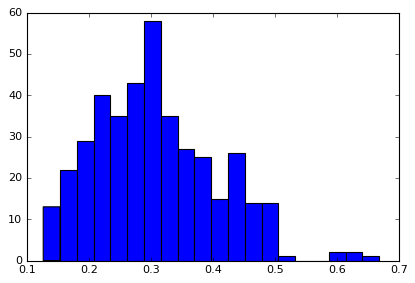

In [67]:
print np.histogram(ICdistro)
plt.hist(ICdistro,bins=20)


In [54]:
for motif in mymotifs:
    print motif,calcAvgIC_v2(mymotifs[motif])

CEBPB 0.377061378644
gataEGca 0.471347884579
CTCF 0.255179254826
NRF1 0.286586239187


### Choose some known motifs based on IC
* One of average: use CEBPB/ or CTCF
* One of 1 std up: IC ~ 1.2
* One of 1 std down: IC ~ 0.7

In [84]:
len_min = 9 # has to be at least this long 
len_max = 15 

low = 0.711
med = 0.948
high = 1.186

#L2 
low = 0.211344880007  
med = 0.30792917321
high = 0.404513466413


ICdict = {}
icfind = low
print icfind
for motif in knownMotifs:
    ic,var = calcAvgIC_v2(knownMotifs[motif])
    ICdict[motif] = ic
    #print ic
    if icfind - 0.010 < ic < icfind +0.010  and var < 0.3:
        length = len(knownMotifs[motif]['A'])
        if length > len_min and length < len_max:
            print motif, ic, getConsensus(knownMotifs[motif])

print "-"*100
icfind = med
print icfind
for motif in knownMotifs:
    ic,var = calcAvgIC_v2(knownMotifs[motif])
    #print ic
    if icfind - 0.010 < ic < icfind +0.010 and var < 0.2:
        length = len(knownMotifs[motif]['A'])
        if length > len_min and length < len_max:
            print motif, ic, getConsensus(knownMotifs[motif])
            
print "-"*100
icfind = high
print icfind
for motif in knownMotifs:
    ic,var= calcAvgIC_v2(knownMotifs[motif])
    #print ic
    if icfind - 0.010 < ic < icfind +0.010 and var < 0.4:
        length = len(knownMotifs[motif]['A'])
        if length > len_min and length < len_max:
            print motif, ic, getConsensus(knownMotifs[motif])

0.211344880007
TBX21_HUMAN.H11MO.0.A 0.215160289739 GTGGAGGTGTGAA
SMAD3_HUMAN.H11MO.0.B 0.220260735647 CTCTGTCACCTG
----------------------------------------------------------------------------------------------------
0.30792917321
ALX1_HUMAN.H11MO.0.B 0.303776420252 ATAATTGAATTA
PBX1_HUMAN.H11MO.0.A 0.307520129132 TGATTGACAG
----------------------------------------------------------------------------------------------------
0.404513466413
BHE40_HUMAN.H11MO.0.A 0.395903904888 GGCACGTGAC
FOXJ3_HUMAN.H11MO.0.A 0.396598405504 TTGTTTATTTTTT
RXRG_HUMAN.H11MO.0.B 0.411977476144 GGTCAAAGGTCAC


### The ones to use:
* High: BHE40    BHE40_HUMAN.H11MO.0.A 0.395903904888 GGCACGTGAC
* Med: PBX1    PBX1_HUMAN.H11MO.0.A 0.307520129132 TGATTGACAG
* Low: SMAD3    SMAD3_HUMAN.H11MO.0.B 0.220260735647 CTCTGTCACCTG

    

In [70]:
for key in knownMotifs:
    if "JUN_" in key or "CREB1" in key or "NANOG" in key:
        print key,calcAvgIC_v2(knownMotifs[key])

NANOG_HUMAN.H11MO.0.A (0.19982330946564983, 0.17603253497876595)
JUN_HUMAN.H11MO.0.A (0.41477205748396456, 0.49113802267636686)
CREB1_HUMAN.H11MO.0.A (0.3451191864433519, 0.40033064395519607)


In [85]:
mToPick = ['SMAD3_HUMAN.H11MO.0.B','PBX1_HUMAN.H11MO.0.A','BHE40_HUMAN.H11MO.0.A']
for m in mToPick:
    print m
    printPWM(knownMotifs[m])
    writeoutPWM(name=m,outfile="motif_inserted/"+m+'.meme',pwm=knownMotifs[m])


SMAD3_HUMAN.H11MO.0.B
A	C	G	T	E	F
0.164	0.364	0.314	0.158
0.11	0.272	0.168	0.45
0.064	0.696	0.06	0.18
0.216	0.004	0.014	0.766
0.07	0.294	0.554	0.082
0.212	0.312	0.106	0.37
0.038	0.87	0.008	0.084
0.466	0.118	0.022	0.394
0.008	0.566	0.332	0.094
0.032	0.912	0.014	0.042
0.352	0.056	0.004	0.588
0.072	0.272	0.494	0.162
PBX1_HUMAN.H11MO.0.A
A	C	G	T	E	F
0.21	0.088	0.202	0.5
0.064	0.09	0.834	0.012
0.868	0.054	0.024	0.054
0.042	0.266	0.34	0.352
0.072	0.076	0.172	0.68
0.038	0.012	0.944	0.006
0.684	0.002	0.306	0.008
0.036	0.858	0.022	0.084
0.684	0.022	0.228	0.066
0.108	0.102	0.686	0.104
BHE40_HUMAN.H11MO.0.A
A	C	G	T	E	F
0.346	0.084	0.37	0.2
0.17	0.014	0.628	0.188
0.098	0.898	0.002	0.002
0.944	0.012	0.016	0.028
0.008	0.93	0.016	0.046
0.052	0.042	0.9	0.006
0.046	0.014	0.046	0.894
0.002	0.0	0.998	0.0
0.584	0.234	0.116	0.066
0.092	0.458	0.38	0.07


In [82]:
pwd

u'/Users/vungo/Work/mepigram_released/testfiles/evaluation'

In [90]:

mymotifs = {}
for key in mToPick:
    print key,key.split("_")[0]
    #print knownMotifs[key]
    print getConsensus(knownMotifs[key])
    mymotifs[key.split('_')[0]] = knownMotifs[key]

#mymotifs



SMAD3_HUMAN.H11MO.0.B SMAD3
CTCTGTCACCTG
PBX1_HUMAN.H11MO.0.A PBX1
TGATTGACAG
BHE40_HUMAN.H11MO.0.A BHE40
GGCACGTGAC


In [109]:
#add the methylation to these motifs
#SMAD3: no. 5 and 6: add EG    0-based
props = {
    'A':0.024376,
    'C':0.085981,
    'G':0.014709,
    'T':0.214204,
    'E':0.660729
        }
loc = 5 
mymotifs['SMAD3'] = insertBaseToPWM_typeE(loc=loc, props=props, pwm=mymotifs['SMAD3'])

props = {
    'A':0.024376,
    'C':0.085981,
    'E':0.014709,
    'T':0.214204,
    'G':0.660729
    }
loc = 6 
mymotifs['SMAD3'] = insertBaseToPWM_typeE(loc=loc, props=props, pwm=mymotifs['SMAD3'])



#PBX1: loc = 7,8
loc = 7
props = {
    'A':0.0,
    'C':0.35,
    'G':0.0,
    'T':0.0,
    'E':0.65
        }

mymotifs['PBX1'] = insertBaseToPWM_typeE(loc=loc, props=props, pwm=mymotifs['PBX1'])

loc = 8
props = {
    'A':0.35,
    'C':0.0,
    'G':0.65,
    'T':0.0,
    'E':0.0
        }

mymotifs['PBX1'] = insertBaseToPWM_typeE(loc=loc, props=props, pwm=mymotifs['PBX1'])

#BHE40: loc = 4
loc = 4
props = {
    'A':0.025,
    'C':0.025,
    'G':0.025,
    'T':0.025,
    'E':0.9
        }

mymotifs['BHE40'] = insertBaseToPWM_typeE(loc=loc, props=props, pwm=mymotifs['BHE40'])


#add the gatEGaca motif too 
gataEGca = {
    'A':[0.1,0.7,0.0,0.8,0.0,0.0,0.1,0.9],
    'C':[0.0,0.1,0.1,0.2,0.2,0.0,0.9,0.0],
    'G':[0.9,0.0,0.0,0.0,0.0,0.8,0.0,0.1],
    'T':[0.0,0.1,0.9,0.0,0.0,0.1,0.0,0.0],
    'E':[0.0,0.1,0.0,0.0,0.8,0.1,0.0,0.0],
}
print getConsensus(gataEGca)
mymotifs['gataEGca'] = gataEGca


GATAEGCA


In [111]:
for key in mymotifs:
    print key,getConsensus(mymotifs[key])
    printPWM(mymotifs[key])
     

PBX1 TGATTGAEGG
A	C	G	T	E	F
0.21	0.088	0.202	0.5	0.0
0.064	0.09	0.834	0.012	0.0
0.868	0.054	0.024	0.054	0.0
0.042	0.266	0.34	0.352	0.0
0.072	0.076	0.172	0.68	0.0
0.038	0.012	0.944	0.006	0.0
0.684	0.002	0.306	0.008	0.0
0.0	0.35	0.0	0.0	0.65
0.35	0.0	0.65	0.0	0.0
0.108	0.102	0.686	0.104	0.0
gataEGca GATAEGCA
A	C	G	T	E	F
0.1	0.0	0.9	0.0	0.0
0.7	0.1	0.0	0.1	0.1
0.0	0.1	0.0	0.9	0.0
0.8	0.2	0.0	0.0	0.0
0.0	0.2	0.0	0.0	0.8
0.0	0.0	0.8	0.1	0.1
0.1	0.9	0.0	0.0	0.0
0.9	0.0	0.1	0.0	0.0
BHE40 GGCAEGTGAC
A	C	G	T	E	F
0.346	0.084	0.37	0.2	0.0
0.17	0.014	0.628	0.188	0.0
0.098	0.898	0.002	0.002	0.0
0.944	0.012	0.016	0.028	0.0
0.025	0.025	0.025	0.025	0.9
0.052	0.042	0.9	0.006	0.0
0.046	0.014	0.046	0.894	0.0
0.002	0.0	0.998	0.0	0.0
0.584	0.234	0.116	0.066	0.0
0.092	0.458	0.38	0.07	0.0
SMAD3 CTCTGEGACCTG
A	C	G	T	E	F
0.164	0.364	0.314	0.158	0.0
0.11	0.272	0.168	0.45	0.0
0.064	0.696	0.06	0.18	0.0
0.216	0.004	0.014	0.766	0.0
0.07	0.294	0.554	0.082	0.0
0.024	0.086	0.015	0.214	0.661
0.024	0.086	0.661	0.214	0.0

In [112]:
## print them out 

for m in mymotifs:
    print m
    #printPWM(mymotifs[m])
    writeoutPWM(name=m,outfile="motif_inserted/"+m+'.typeE.meme',pwm=mymotifs[m])

PBX1
gataEGca
BHE40
SMAD3


### Make sequences randomly

In [5]:
import random
import itertools
import bisect
import numpy as np

def randomseqDimer(props,length):
    """
    Generate string randomly at certain length
    - props: a dict of dimers probability for DNA 
    
    """
    #choices, weights = fprob_table.items()
    fprob_table = props
    K = length
    choices = []
    weights = []
    for key in fprob_table:
        choices += [key]
        weights += [fprob_table[key]]
    #cumdist = list(itertools.accumulate(weights))
    cumdist = []
    cumprop = 0.0
    for i in range(len(choices)):
        cumprop += weights[i]
        cumdist += [cumprop]
    results = []
    s = ""
    while len(s) < K:
        x = random.random() * cumdist[-1]
        s += choices[bisect.bisect(cumdist, x)]
        #print s

    return s

In [6]:
### getting the dimer props 

backgroundfile = "../test_data_typeE/background_typeE-5.tsv"
lines = open(backgroundfile).readlines()

dimercount = {}
for line in lines[1:]:
    #print line.strip()
    tmp = line.strip().split()
    seq = tmp[0]
    k = 2 
    multiplier = int(tmp[1])
    for i in range(len(seq) - k + 1):
        dimer = seq[i:i+k]
        try: 
            dimercount[dimer] += multiplier*1
        except KeyError:
            dimercount[dimer] = multiplier*1 
dimerProps = {}
total = 0.0
for key in dimercount:
    total += dimercount[key]
for key in dimercount:
    dimerProps[key] = dimercount[key]/total
#dimerProps

In [113]:
abundances = [0.01,0.02,0.05,0.1,0.25]
sizes = [250, 1000, 5000, 20000]
seq_length_avg = 250
seq_length_std = 50

resultdir = './files/SIM_seqs_2/'
for motif in mymotifs:
    print motif
    seqsets = {} 
    for a in abundances:
        for siz in sizes:
            name = str(a) + '_' + str(siz)
            print name
            outfile = open(resultdir + motif+'_'+name+'.faa','w')
            
            seq_set = {}
            for i in range(siz):
                seqlength = int(np.random.normal(scale=seq_length_std, loc=seq_length_avg))
                seq = randomseqDimer(props=dimerProps,length=seqlength)
                seq_set[i] = seq 
            # now , insert the motif to the seqs
            numtoinsert = int(a*siz) + 1
            print numtoinsert
            seq_set = insertoseqs(numseqtopick=numtoinsert,pwm=mymotifs[motif],seqs=seq_set)
            
            #write out the fasta file 
            for key in seq_set:
                line = ">"+str(key)+'\n'+seq_set[key]
                outfile.write(line+'\n')
            outfile.close()
        
        


PBX1
0.01_250
3
0.01_1000
11
0.01_5000
51
0.01_20000
201
0.02_250
6
0.02_1000
21
0.02_5000
101
0.02_20000
401
0.05_250
13
0.05_1000
51
0.05_5000
251
0.05_20000
1001
0.1_250
26
0.1_1000
101
0.1_5000
501
0.1_20000
2001
0.25_250
63
0.25_1000
251
0.25_5000
1251
0.25_20000
5001
gataEGca
0.01_250
3
0.01_1000
11
0.01_5000
51
0.01_20000
201
0.02_250
6
0.02_1000
21
0.02_5000
101
0.02_20000
401
0.05_250
13
0.05_1000
51
0.05_5000
251
0.05_20000
1001
0.1_250
26
0.1_1000
101
0.1_5000
501
0.1_20000
2001
0.25_250
63
0.25_1000
251
0.25_5000
1251
0.25_20000
5001
BHE40
0.01_250
3
0.01_1000
11
0.01_5000
51
0.01_20000
201
0.02_250
6
0.02_1000
21
0.02_5000
101
0.02_20000
401
0.05_250
13
0.05_1000
51
0.05_5000
251
0.05_20000
1001
0.1_250
26
0.1_1000
101
0.1_5000
501
0.1_20000
2001
0.25_250
63
0.25_1000
251
0.25_5000
1251
0.25_20000
5001
SMAD3
0.01_250
3
0.01_1000
11
0.01_5000
51
0.01_20000
201
0.02_250
6
0.02_1000
21
0.02_5000
101
0.02_20000
401
0.05_250
13
0.05_1000
51
0.05_5000
251
0.05_20000
1001
0.1_250

In [13]:
for motif in mymotifs:
    print motif

CEBPB
gataEGca
CTCF
NRF1


In [20]:
for m in mymotifs:
    writeoutPWM(name='1',outfile=m+".SIM.typeE.meme",pwm=mymotifs[m])